Collecting data using API:

In [2]:
%pip install seaborn

In [4]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor

We used the TMDb API to retrieve the top 550 movies based on ratings. First, we fetched movie IDs using the top-rated movies endpoint, handling pagination to gather the required number of entries. Then, for each movie ID, we retrieved detailed information such as title, release year, IMDb rating, vote count, genres, and runtime. The collected data was stored in a pandas DataFrame, with a 'Rank' column added based on the index. Finally, we structured and saved the dataset as a CSV file (Raw_Data.csv) for further analysis.

In [5]:
# TMDb API key
api_key = '365978475adad9f2f69fa506de43a2ed'

# Function to fetch movie details from TMDb API
def fetch_movie_data(movie_id):
    url = f"https://api.themoviedb.org/3/movie/{movie_id}?api_key={api_key}&language=en-US"
    response = requests.get(url)

    if response.status_code == 200:
        try:
            data = response.json()
            return {
                "Title": data.get("title"),
                "Year": data.get("release_date", "").split("-")[0],  # Get the release year
                "IMDb Rating": data.get("vote_average"),
                "Votes": data.get("vote_count"),
                "Genre": ', '.join([genre['name'] for genre in data.get("genres", [])]),
                "Runtime": f"{data.get('runtime', 0)} min"
            }
        except ValueError:
            print(f"Error decoding JSON for movie ID {movie_id}")
    else:
        print(f"Request failed for movie ID {movie_id}. Status code: {response.status_code}")
    return None

# Function to fetch the list of top-rated movies from TMDb
def fetch_top_rated_movies(limit=550):
    all_movie_ids = []
    page = 1
    while len(all_movie_ids) < limit:
        url = f"https://api.themoviedb.org/3/movie/top_rated?api_key={api_key}&language=en-US&page={page}"
        response = requests.get(url)

        if response.status_code == 200:
            try:
                data = response.json()
                # Add movies from this page to the list, ensuring we do not exceed the limit
                all_movie_ids.extend([movie['id'] for movie in data['results']])
                if len(all_movie_ids) >= limit:
                    break
                page += 1
            except ValueError:
                print("Error decoding JSON for top-rated movies")
        else:
            print(f"Request failed for page {page}. Status code: {response.status_code}")
            break
    return all_movie_ids[:limit]  # Limit the result to exactly 'limit' movies

# Get the list of top 550 movie IDs
movie_ids = fetch_top_rated_movies(limit=550)

# Create an empty list to store movie data
movie_data = []

# Loop through the list of movie IDs and fetch data for each movie
for movie_id in movie_ids:
    movie_info = fetch_movie_data(movie_id)
    if movie_info:
        movie_data.append(movie_info)

# Convert the movie data list into a pandas DataFrame
df = pd.DataFrame(movie_data)

# Add the 'Rank' column, based on the index of the DataFrame
df['Rank'] = df.index + 1  # Adding 1 to index for rank starting from 1

# Reorder columns to put 'Rank' first and remove 'TMDb ID'
df = df[['Rank', 'Title', 'Year', 'IMDb Rating', 'Votes', 'Genre', 'Runtime']]

# Display the DataFrame
print(df)

# save the DataFrame to a CSV file
df.to_csv("Raw_Data.csv", index=False)

     Rank                          Title  Year  IMDb Rating  Votes  \
0       1       The Shawshank Redemption  1994        8.709  28212   
1       2                  The Godfather  1972        8.687  21388   
2       3          The Godfather Part II  1974        8.571  12923   
3       4               Schindler's List  1993        8.565  16396   
4       5                   12 Angry Men  1957        8.548   9096   
..    ...                            ...   ...          ...    ...   
545   546             To Be or Not to Be  1942        7.800    755   
546   547  Teen Titans: Trouble in Tokyo  2006        7.827    416   
547   548                Rosemary's Baby  1968        7.827   4034   
548   549                    Ratatouille  2007        7.826  17457   
549   550              World of Tomorrow  2015        7.825    332   

                                            Genre  Runtime  
0                                    Drama, Crime  142 min  
1                                    

We performed data preprocessing on the raw movie dataset to ensure quality and consistency. First, we removed duplicate rows and handled missing values by dropping entries with essential missing data. Then, we converted 'Year', 'IMDb Rating', and 'Votes' to appropriate numeric types for accurate analysis. The 'Genre' column was cleaned by stripping extra spaces, and 'Runtime' was transformed into an integer format by removing the "min" text. Finally, we saved the cleaned dataset as "Cleaned_Data.csv" for further use.

In [6]:
#Preprocessing

# Load the raw movie dataset
df = pd.read_csv("Raw_Data.csv")

# Remove duplicate rows
df = df.drop_duplicates()

# Handle missing values (drop rows with missing essential data)
df = df.dropna(subset=["Title", "Year", "IMDb Rating", "Votes", "Genre", "Runtime"])

# Convert 'Year' to integer
df["Year"] = pd.to_numeric(df["Year"], errors="coerce").fillna(0).astype(int)

# Convert 'IMDb Rating' and 'Votes' to appropriate numeric types
df["IMDb Rating"] = pd.to_numeric(df["IMDb Rating"], errors="coerce").fillna(0)
df["Votes"] = pd.to_numeric(df["Votes"], errors="coerce").fillna(0)

# Clean 'Genre' column by removing extra spaces and ensuring it's properly formatted
df["Genre"] = df["Genre"].str.strip()

# Convert 'Runtime' to numeric format (remove "min" and convert to integer)
df["Runtime"] = df["Runtime"].str.replace(" min", "", regex=True)
df["Runtime"] = pd.to_numeric(df["Runtime"], errors="coerce").fillna(0).astype(int)

# Save the cleaned dataset
df.to_csv("Cleaned_Data.csv", index=False)

# Display the first few rows of the cleaned data
print(df.head())

   Rank                     Title  Year  IMDb Rating  Votes  \
0     1  The Shawshank Redemption  1994        8.709  28212   
1     2             The Godfather  1972        8.687  21388   
2     3     The Godfather Part II  1974        8.571  12923   
3     4          Schindler's List  1993        8.565  16396   
4     5              12 Angry Men  1957        8.548   9096   

                 Genre  Runtime  
0         Drama, Crime      142  
1         Drama, Crime      175  
2         Drama, Crime      202  
3  Drama, History, War      195  
4                Drama       97  


In [7]:
movies = pd.read_csv("Cleaned_Data.csv")

We analyzed the correlation between Rank and Votes to understand their relationship. First, we extracted the relevant columns and computed the correlation matrix using .corr(). Then, we visualized the correlation using a heatmap with annotations for clarity. This helps identify whether higher-ranked movies tend to have more votes, providing insights into audience engagement.

           Rank     Votes
Rank   1.000000 -0.264707
Votes -0.264707  1.000000


<Axes: title={'center': 'Correlation between Rank and Voting'}>

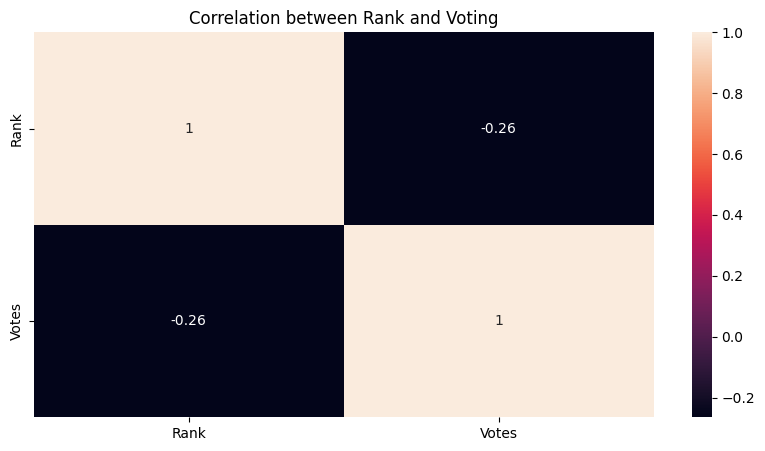

In [8]:
rank_votes_data = movies[['Rank','Votes']]
correlation = rank_votes_data.corr()
print(correlation)
plt.figure(figsize=(10,5))
plt.title('Correlation between Rank and Voting')
sns.heatmap(correlation, annot=True)

We analyzed the impact of genre diversity on IMDb ratings and votes. First, we created a new column, 'Multiple_Genres', which identifies whether a movie belongs to multiple genres. After cleaning missing values, we used box plots to compare IMDb ratings and vote counts between single-genre and multi-genre movies. This visualization helps identify whether multi-genre films receive higher ratings or more votes than single-genre films.

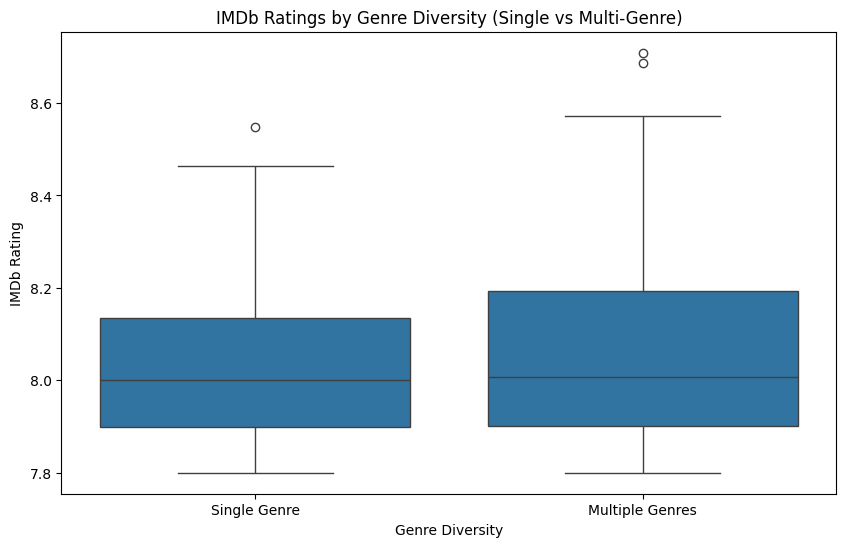

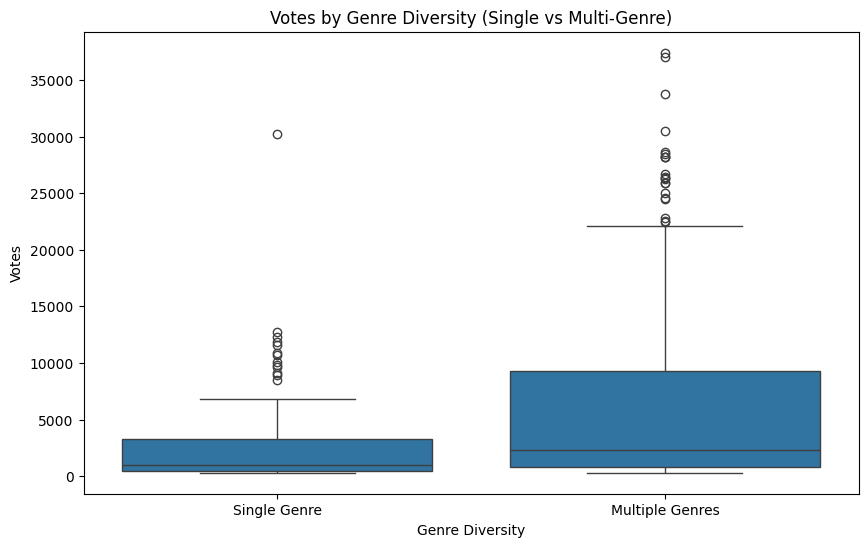

In [9]:
movies['Genre'] = movies['Genre'].astype(str)
movies['Multiple_Genres'] = movies['Genre'].apply(lambda x: ',' in x)
movies_clean = movies.dropna(subset=['IMDb Rating', 'Votes'])
plt.figure(figsize=(10, 6))
sns.boxplot(data=movies_clean, x='Multiple_Genres', y='IMDb Rating')
plt.title('IMDb Ratings by Genre Diversity (Single vs Multi-Genre)')
plt.xlabel('Genre Diversity')
plt.ylabel('IMDb Rating')
plt.xticks([0, 1], ['Single Genre', 'Multiple Genres'])
plt.show()
plt.figure(figsize=(10, 6))
sns.boxplot(data=movies_clean, x='Multiple_Genres', y='Votes')
plt.title('Votes by Genre Diversity (Single vs Multi-Genre)')
plt.xlabel('Genre Diversity')
plt.ylabel('Votes')
plt.xticks([0, 1], ['Single Genre', 'Multiple Genres'])
plt.show()


We analyzed the correlation between movie runtime and IMDb rating to see if longer movies tend to have higher ratings. First, we extracted the relevant columns and computed the correlation matrix. Then, we visualized the correlation using a heatmap with annotations for clarity. This helps in understanding the relationship between a movie’s length and its audience reception.

              Runtime  IMDb Rating
Runtime      1.000000     0.182231
IMDb Rating  0.182231     1.000000


<Axes: title={'center': 'Correlation between Movie Runtime and IMDb Rating'}>

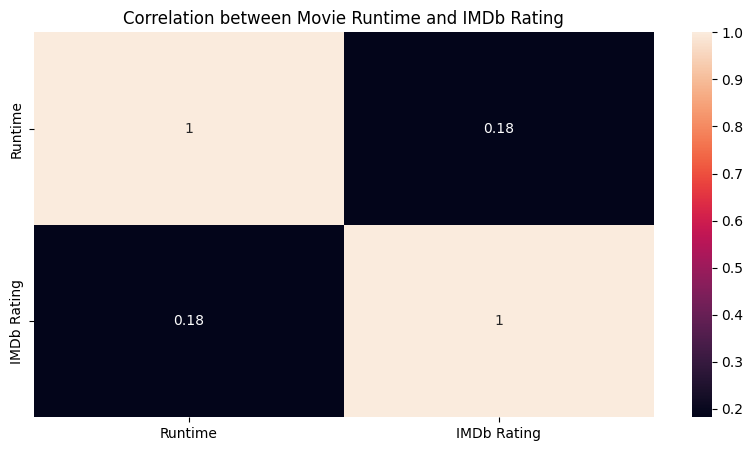

In [10]:
runtime_rating_data = movies[['Runtime', 'IMDb Rating']]
correlation = runtime_rating_data.corr()
print(correlation)
plt.figure(figsize=(10,5))
plt.title('Correlation between Movie Runtime and IMDb Rating')
sns.heatmap(correlation, annot=True)

We analyzed the **average IMDb ratings** of movies from the **15 most recent years** in the dataset. First, we identified the **latest 15 years**, then filtered movies released in those years. We grouped the data by **year** and calculated the **average IMDb rating** for each. Finally, we visualized the trend using a **bar chart**, with data labels on top of each bar for clarity. This helps in understanding how movie ratings have evolved over recent years.

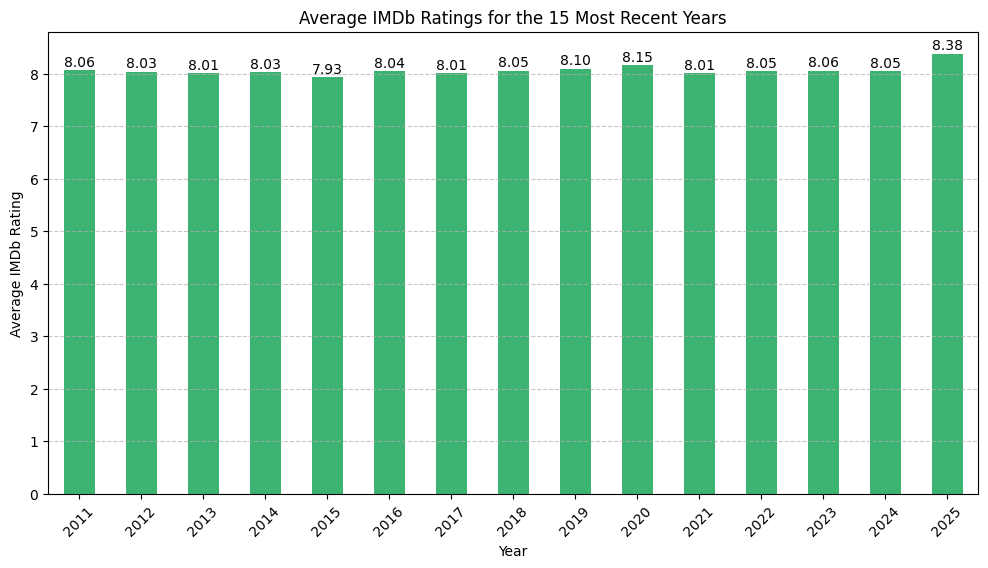

In [11]:
# Identify the 15 most recent years in the dataset
recent_years = movies['Year'].dropna().unique()  # Remove any NaN values if present
recent_years = sorted(recent_years, reverse=True)[:15]  # Get the 15 most recent years

# Filter data for the 15 most recent years
recent_movies = movies[movies['Year'].isin(recent_years)]

# Group by Year and calculate average IMDb Rating
avg_rating_recent_years = recent_movies.groupby('Year')['IMDb Rating'].mean()

# Sort years in chronological order for better visualization
avg_rating_recent_years = avg_rating_recent_years.sort_index()

# Bar plot to show the average IMDb Ratings for the 15 most recent years
plt.figure(figsize=(12, 6))
avg_rating_recent_years.plot(kind='bar', color='mediumseagreen')
plt.title('Average IMDb Ratings for the 15 Most Recent Years')
plt.xlabel('Year')
plt.ylabel('Average IMDb Rating')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Add gridlines for clarity

# Add data labels on top of each bar
for index, value in enumerate(avg_rating_recent_years):
    plt.text(index, value + 0.02, f'{value:.2f}', ha='center', va='bottom')

plt.show()

We analyzed the relationship between **movie genres** and **IMDb rating ranges**. First, we cleaned the **'Genre'** column to ensure consistent naming and identified the **top 20 most common genres**. Then, we categorized movies into **rating ranges** (1-4, 5-6, 7-8, 9-10) and created a **genre vs. rating matrix** using a cross-tabulation. Finally, we visualized this data using a **heatmap**, highlighting how different genres distribute across IMDb rating ranges. This helps in understanding which genres tend to receive higher or lower ratings.

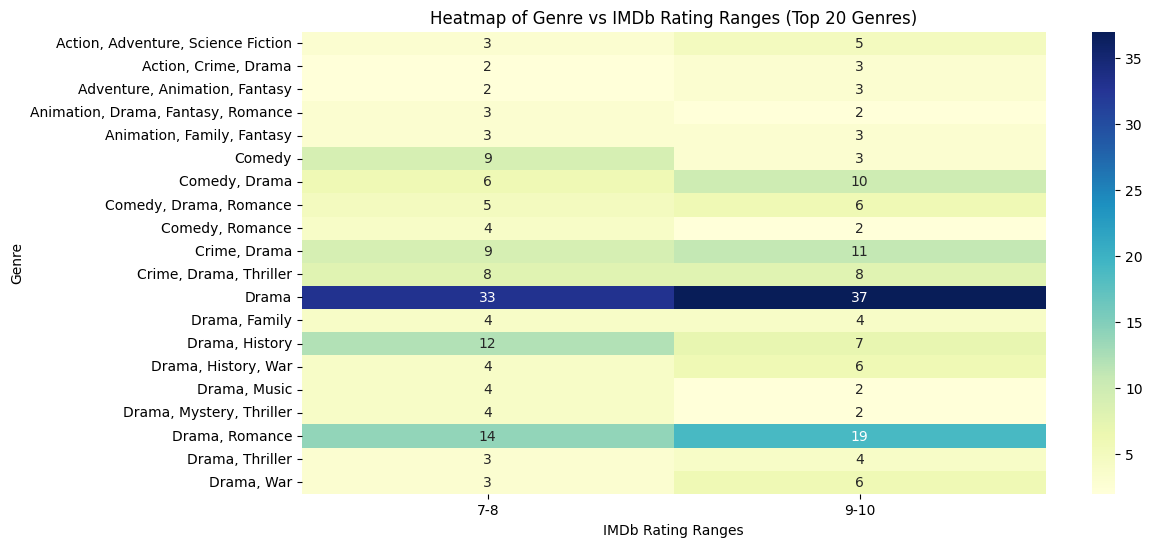

In [12]:
# Clean the 'Genre' column to ensure consistent naming
movies['Genre_Clean'] = movies['Genre'].apply(lambda x: ', '.join(sorted(x.split(', '))))

# Get the top 20 most common genres
top_genres = movies['Genre_Clean'].value_counts().head(20).index

# Filter the data to only include top genres
filtered_movies = movies[movies['Genre_Clean'].isin(top_genres)].copy()  # Make a copy to avoid SettingWithCopyWarning

# Create the 'Rating_Range' column using .loc
filtered_movies['Rating_Range'] = pd.cut(filtered_movies['IMDb Rating'], bins=[0, 4, 6, 8, 10], labels=['1-4', '5-6', '7-8', '9-10'])

# Create a genre vs. rating matrix
genre_matrix = pd.crosstab(filtered_movies['Genre_Clean'], filtered_movies['Rating_Range'])

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(genre_matrix, annot=True, cmap='YlGnBu', fmt='d', cbar=True)
plt.title('Heatmap of Genre vs IMDb Rating Ranges (Top 20 Genres)')
plt.xlabel('IMDb Rating Ranges')
plt.ylabel('Genre')
plt.show()

# **Exploratory Data Analysis(EDA):**


## 1. Exploratory Data Analysis (EDA) on Primary Data

### 1.1 Load data:

In [14]:
df_primary = pd.read_csv("Datasets/RawData/Primary_Raw_Data.csv")

### 1.2 Data Overview:

In [15]:
print(df_primary.info())
print(df_primary.describe())
print(df_primary.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550 entries, 0 to 549
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Rank         550 non-null    int64  
 1   Title        550 non-null    object 
 2   Year         550 non-null    int64  
 3   IMDb Rating  550 non-null    float64
 4   Votes        550 non-null    int64  
 5   Genre        550 non-null    object 
 6   Runtime      550 non-null    object 
dtypes: float64(1), int64(3), object(3)
memory usage: 23.7+ KB
None
             Rank         Year  IMDb Rating         Votes
count  550.000000   550.000000   550.000000    550.000000
mean   275.500000  1995.616364     8.055222   5328.227273
std    158.915596    26.268200     0.184201   6914.026738
min      1.000000  1902.000000     7.800000    300.000000
25%    138.250000  1977.250000     7.900000    712.000000
50%    275.500000  2004.000000     8.000000   2060.000000
75%    412.750000  2018.000000     8.178500 

### 1.3 Missing Values and Data Types:


In [16]:
# Check for missing values
missing_values = df_primary.isnull().sum()
print(missing_values)

# Check data types of columns
data_types = df_primary.dtypes
print(data_types)

Rank           0
Title          0
Year           0
IMDb Rating    0
Votes          0
Genre          0
Runtime        0
dtype: int64
Rank             int64
Title           object
Year             int64
IMDb Rating    float64
Votes            int64
Genre           object
Runtime         object
dtype: object


### 1.4 statistical summary:

In [17]:
# Display basic descriptive statistics for numerical columns
stat_summary = df_primary.describe()
print("Statistical Summary:\n", stat_summary)

Statistical Summary:
              Rank         Year  IMDb Rating         Votes
count  550.000000   550.000000   550.000000    550.000000
mean   275.500000  1995.616364     8.055222   5328.227273
std    158.915596    26.268200     0.184201   6914.026738
min      1.000000  1902.000000     7.800000    300.000000
25%    138.250000  1977.250000     7.900000    712.000000
50%    275.500000  2004.000000     8.000000   2060.000000
75%    412.750000  2018.000000     8.178500   8048.750000
max    550.000000  2024.000000     8.708000  36985.000000


### 1.5  Univariate Analysis:

In [18]:
df_primary["Runtime"] = df_primary["Runtime"].str.extract(r"(\d+)").astype(float)

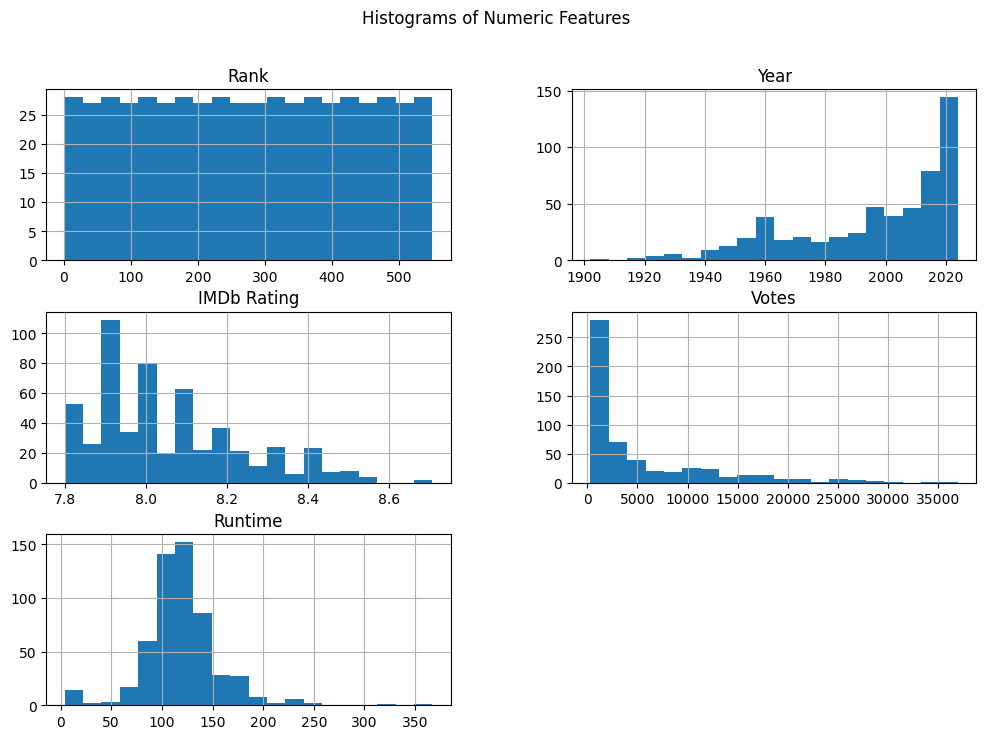

In [19]:
# 1.5.1 Histograms for numeric features (Rank, Year, IMDb Rating, Votes)
df_primary[['Rank', 'Year', 'IMDb Rating', 'Votes','Runtime']].hist(bins=20, figsize=(12, 8))
plt.suptitle('Histograms of Numeric Features')
plt.show()

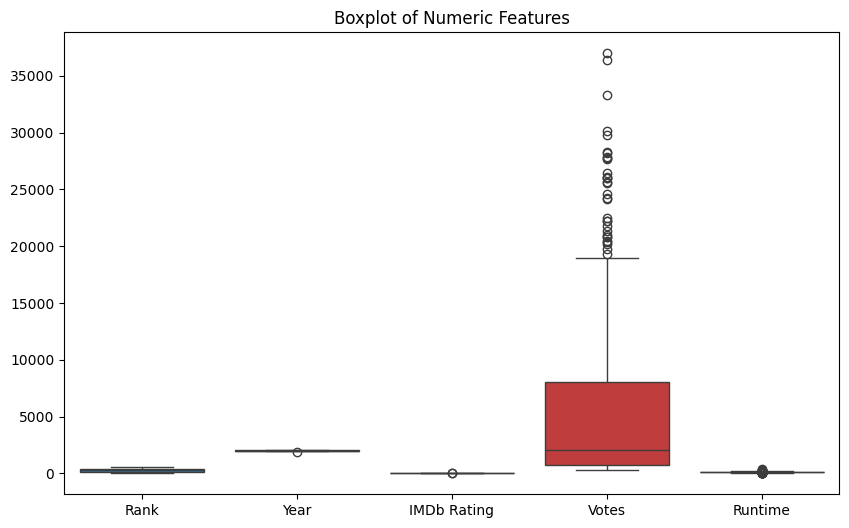

In [20]:
# 1.5.2 Boxplots to detect outliers in numeric features
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_primary[['Rank', 'Year', 'IMDb Rating', 'Votes','Runtime']])
plt.title('Boxplot of Numeric Features')
plt.show()

In [21]:
# 1.5.3 Descriptive statistics for individual numeric columns (Rank, Year, IMDb Rating, Votes)
print("Descriptive statistics for IMDb Rating:\n", df_primary['IMDb Rating'].describe())
print("Descriptive statistics for Votes:\n", df_primary['Votes'].describe())

Descriptive statistics for IMDb Rating:
 count    550.000000
mean       8.055222
std        0.184201
min        7.800000
25%        7.900000
50%        8.000000
75%        8.178500
max        8.708000
Name: IMDb Rating, dtype: float64
Descriptive statistics for Votes:
 count      550.000000
mean      5328.227273
std       6914.026738
min        300.000000
25%        712.000000
50%       2060.000000
75%       8048.750000
max      36985.000000
Name: Votes, dtype: float64


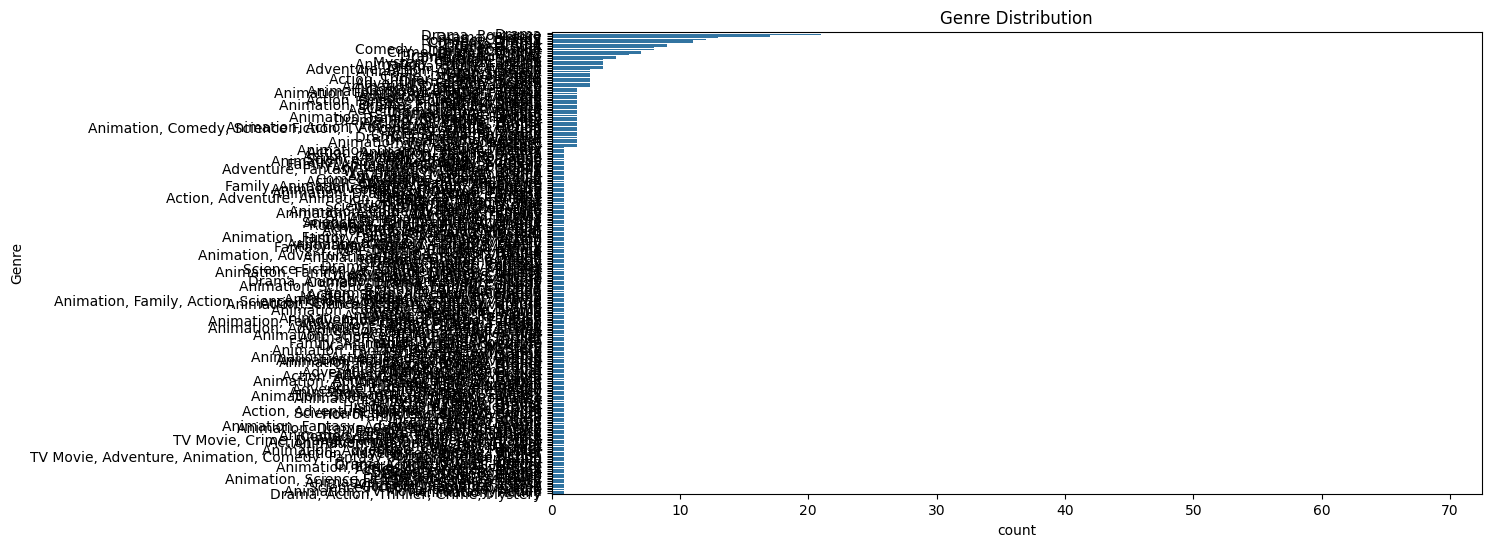

In [22]:
# 1.5.4 Frequency distribution of genres (categorical data)
plt.figure(figsize=(12, 6))
sns.countplot(y=df_primary['Genre'], order=df_primary['Genre'].value_counts().index)
plt.title('Genre Distribution')
plt.show()

### 1.6  Multivariate Analysis:

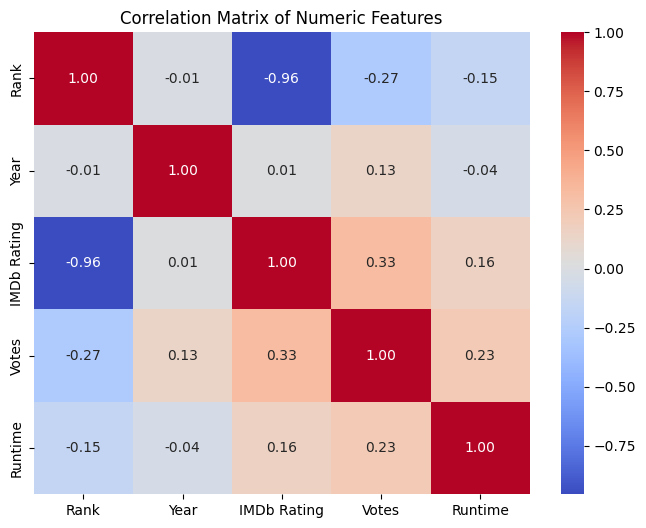

In [23]:
# 1.6.1 Correlation matrix between numeric variables (Rank, Year, IMDb Rating, Votes)
correlation_matrix = df_primary[['Rank', 'Year', 'IMDb Rating', 'Votes','Runtime']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numeric Features')
plt.show()

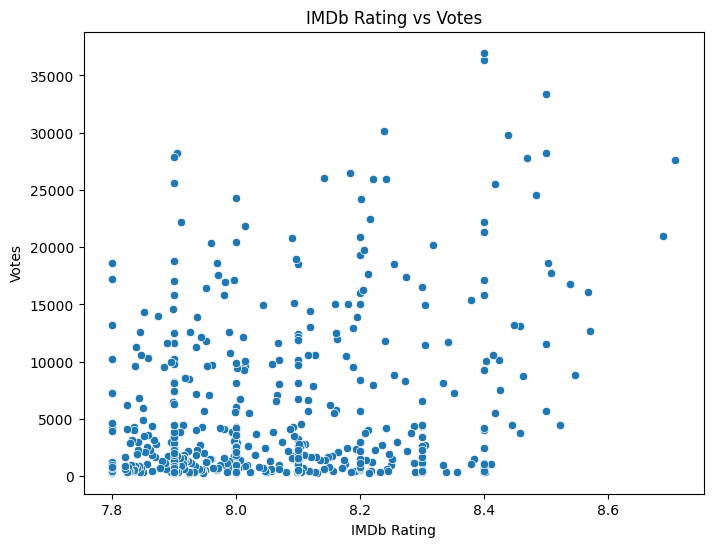

In [24]:
# 1.6.2 Scatter plot to check the relationship between IMDb Rating and Votes
plt.figure(figsize=(8, 6))
sns.scatterplot(x='IMDb Rating', y='Votes', data=df_primary)
plt.title('IMDb Rating vs Votes')
plt.show()

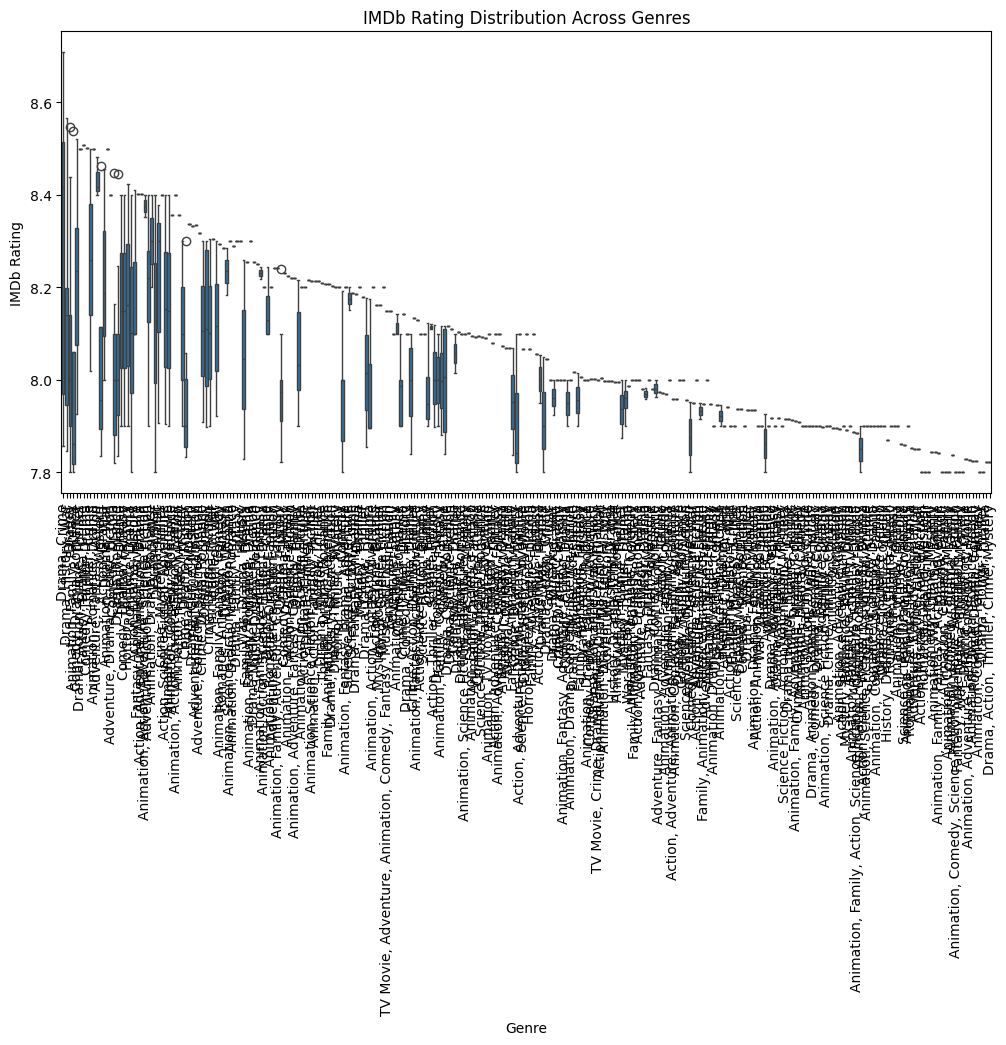

In [25]:
## Categorical vs Numeric

# 1.6.3 Boxplot for IMDb Rating across different genres (categorical vs numeric)
plt.figure(figsize=(12, 6))
sns.boxplot(x='Genre', y='IMDb Rating', data=df_primary)
plt.xticks(rotation=90)
plt.title('IMDb Rating Distribution Across Genres')
plt.show()

### 1.7 Other Visualizations:

Trends Over Time: Line plots are used to visualize how IMDb Rating and Votes have changed over the years.

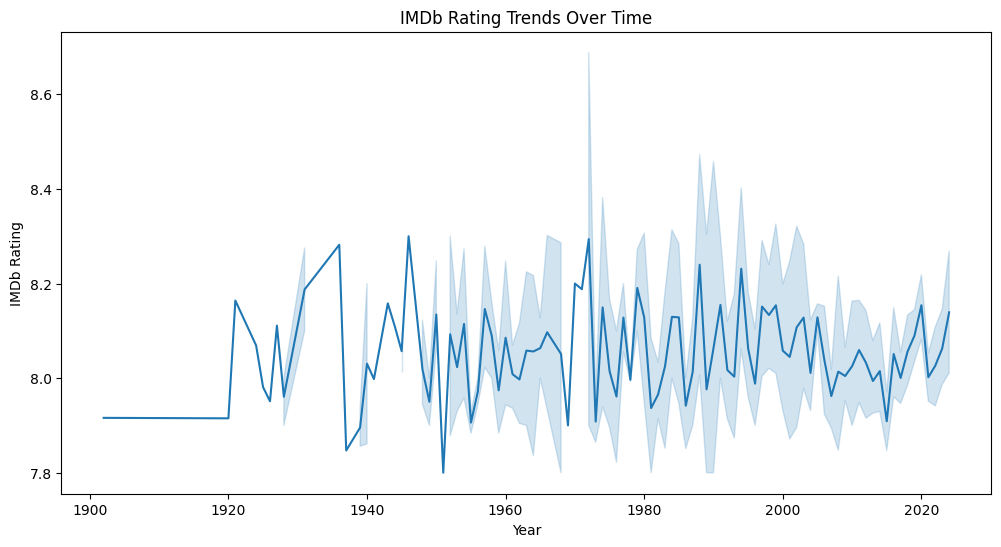

In [26]:
# 1.7.1 Year-wise distribution of IMDb Ratings (checking trends over time)
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='IMDb Rating', data=df_primary)
plt.title('IMDb Rating Trends Over Time')
plt.show()

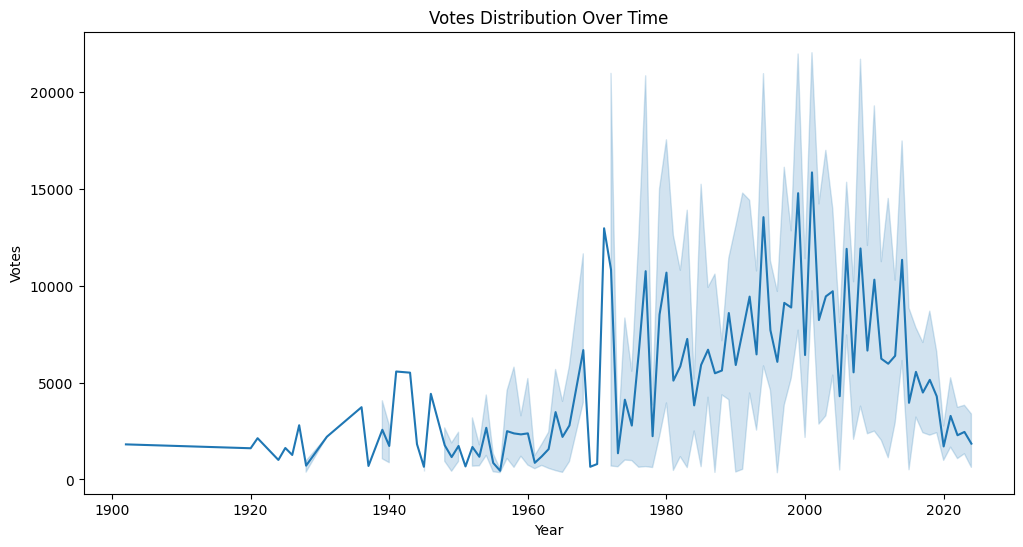

In [27]:
# 1.7.2 Votes distribution by Year (checking how vote counts vary across years)
plt.figure(figsize=(12, 6))
sns.lineplot(x='Year', y='Votes', data=df_primary)
plt.title('Votes Distribution Over Time')
plt.show()

--------------------

## 2. Exploratory Data Analysis (EDA) on Secondery Data

### 2.1 Load data:

In [29]:
df = pd.read_csv('Datasets/RawData/Secondary_Raw_Data.csv')

### 2.2 Data Overview:

In [30]:
# Display basic information
print(df.info())  # Data types and missing values
print(df.describe())
print(df.head())  # First 5 rows
print(df.columns)  # Column names

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10880 entries, 0 to 10879
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Rank                  10880 non-null  int64  
 1   Title                 10880 non-null  object 
 2   Type                  10880 non-null  object 
 3   Premiere              10837 non-null  float64
 4   Genre                 10780 non-null  object 
 5   Watchtime             10880 non-null  object 
 6   Watchtime in Million  10880 non-null  object 
dtypes: float64(1), int64(1), object(5)
memory usage: 382.6+ KB
None
               Rank      Premiere
count  10880.000000  10837.000000
mean   10715.449449   2013.578758
std     4917.903231      9.548337
min       14.000000   1951.000000
25%     6783.750000   2011.000000
50%    11370.500000   2017.000000
75%    14951.500000   2020.000000
max    18214.000000   2023.000000
   Rank                   Title   Type  Premiere     Genre

### 2.3 Some improvements :
the Watchtime and Watchtime in Million columns were cleaned by removing commas (,) and the letter M, then converted to float. The Watchtime values were multiplied by 1,000,000 to convert millions into whole numbers, while Watchtime in Million remained as-is since it already represents millions.

In [31]:
#remove the rowes that contan NaN in Premiere
df = df.dropna(subset=['Premiere'])
#Convert Premiere column to int after removing missing values
df['Premiere'] = df['Premiere'].astype(int)
df["Watchtime"] = df["Watchtime"].astype(str).str.replace(",", "").str.replace("M", "").astype(float) * 1_000_000
df["Watchtime in Million"] = df["Watchtime in Million"].astype(str).str.replace(",", "").str.replace("M", "").astype(float)
print(df.dtypes)

Rank                      int64
Title                    object
Type                     object
Premiere                  int32
Genre                    object
Watchtime               float64
Watchtime in Million    float64
dtype: object


### 2.4 Descriptive Statistics:
Now we need to get the basic statistics for each numerical column:

In [32]:
print(df[['Rank', 'Watchtime', 'Watchtime in Million']].describe())

               Rank     Watchtime  Watchtime in Million
count  10837.000000  1.083700e+04          10837.000000
mean   10699.797638  2.331734e+12              2.331734
std     4917.211742  7.956474e+12              7.956474
min       14.000000  1.000000e+11              0.100000
25%     6766.000000  1.000000e+11              0.100000
50%    11353.000000  4.000000e+11              0.400000
75%    14931.000000  1.500000e+12              1.500000
max    18214.000000  2.499000e+14            249.900000


### 2.5 Visualization:
We will use charts to discover patterns:
but first we do some improvements for the Premiere

#### 2.5.1 Analysis of the number of films by year:

Empty DataFrame
Columns: [Rank, Title, Type, Premiere, Genre, Watchtime, Watchtime in Million]
Index: []


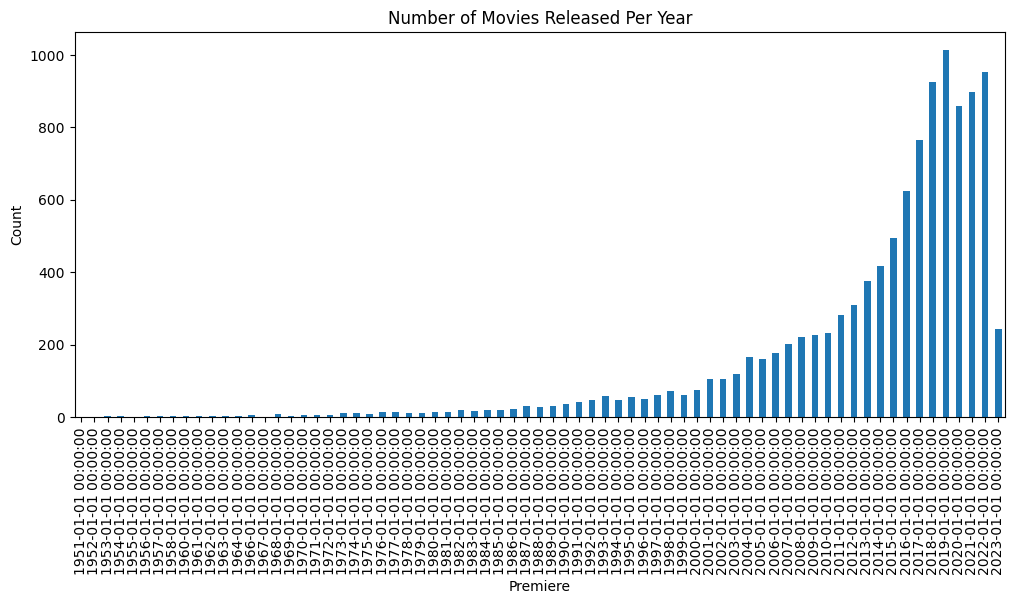

In [33]:
import pandas as pd
import matplotlib.pyplot as plt
# Convert the Premiere column to date type by adding -01-01 (first day of the year)
df['Premiere'] = pd.to_datetime(df['Premiere'].astype(str) + '-01-01', format='%Y-%m-%d', errors='coerce')
# Check for invalid or empty dates
print(df[df['Premiere'].isna()])
df['Premiere'].value_counts().sort_index().plot(kind='bar', figsize=(12, 5))
plt.title("Number of Movies Released Per Year")
plt.xlabel("Premiere")
plt.ylabel("Count")
plt.show()

#### 2.5.2 distribution diagram for Watchtime :

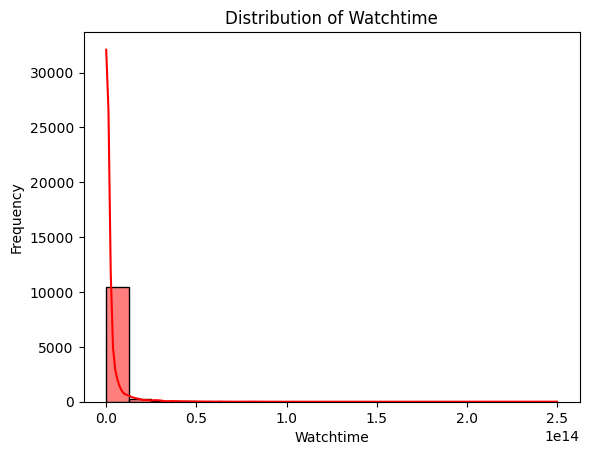

In [34]:
sns.histplot(df["Watchtime"], bins=20, kde=True, color='red')
plt.title("Distribution of Watchtime")
plt.xlabel("Watchtime")
plt.ylabel("Frequency")
plt.show()

### 2.5.3 Most popular movie genres:

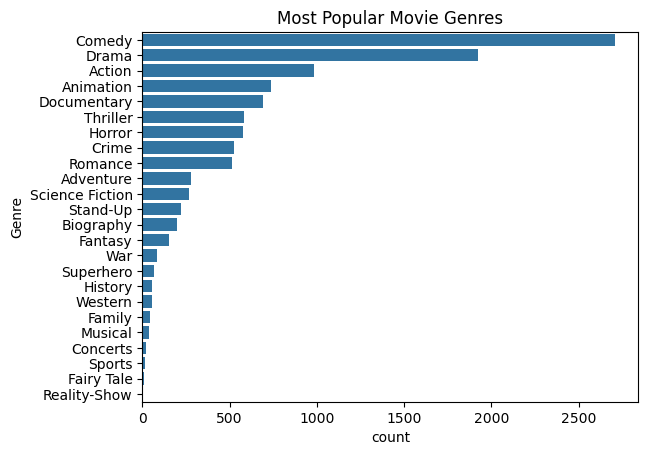

In [35]:
sns.countplot(y="Genre", data=df, order=df['Genre'].value_counts().index)
plt.title("Most Popular Movie Genres")
plt.show()


### 2.6 Correlation Analysis:
Now we analyze the correlation between Watchtime and Watchtime in Million

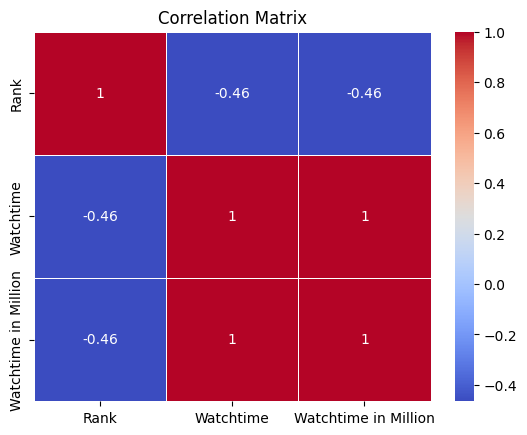

In [36]:
corr_matrix = df[['Rank', 'Watchtime', 'Watchtime in Million']].corr()

sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

In [37]:
# Show movies with the highest viewing time
top_movies = df[['Title', 'Watchtime', 'Rank']].sort_values(by='Watchtime', ascending=False).head(10)
print(top_movies)

                               Title     Watchtime  Rank
0                         The Mother  2.499000e+14    14
1             Luther: The Fallen Sun  2.097000e+14    20
2                       Extraction 2  2.018000e+14    23
3                         You People  1.818000e+14    29
4                   Murder Mystery 2  1.736000e+14    33
5                 Your Place or Mine  1.630000e+14    37
6  Glass Onion: A Knives Out Mystery  1.429000e+14    52
7                    We Have a Ghost  1.244000e+14    69
8                  The Pale Blue Eye  1.205000e+14    72
9                                AKA  1.200000e+14    74


### 2.7 Bias Analysis:
In this step, we check for any potential bias based on the movies’ genre or release year. For example, if some genres (such as Action or Drama) are overrepresented than others, this could affect the results of the analysis. Also, if the data contains an unbalanced number of movies in certain years, this could bias the conclusions.

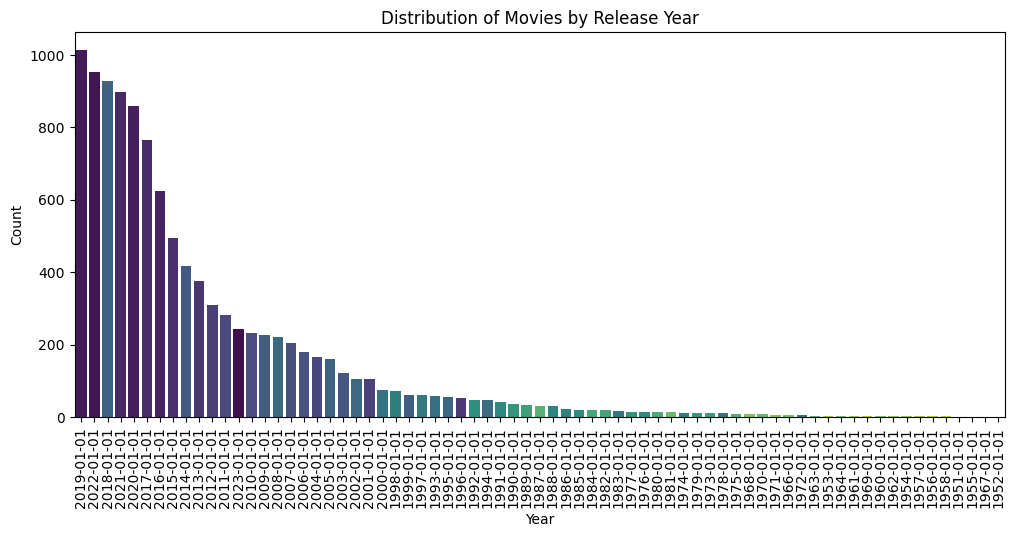

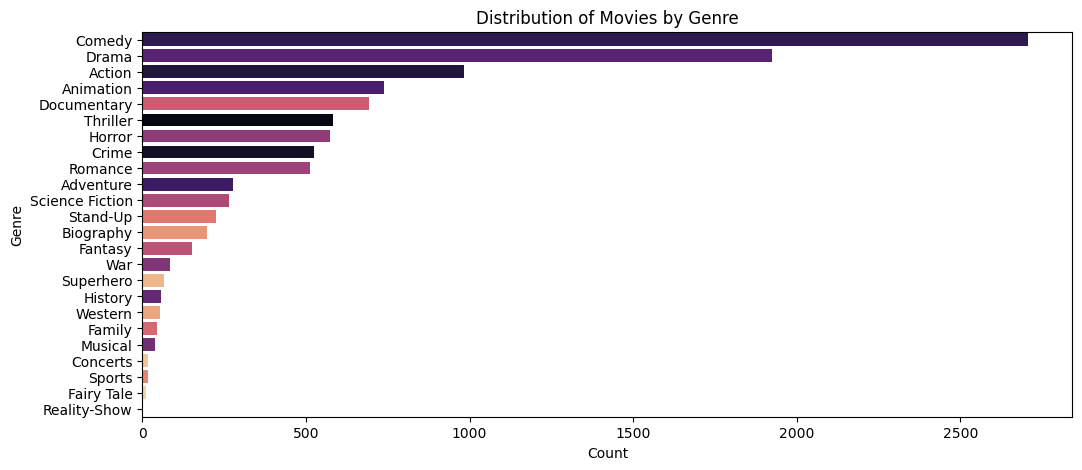

In [38]:
# Bias analysis based on release year
plt.figure(figsize=(12, 5))
sns.countplot(x="Premiere", data=df, order=df["Premiere"].value_counts().index, hue="Premiere", legend=False, palette="viridis")
plt.title("Distribution of Movies by Release Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

# Bias analysis based on movie genre
plt.figure(figsize=(12, 5))
sns.countplot(y="Genre", data=df, order=df["Genre"].value_counts().index, hue="Genre", legend=False, palette="magma")
plt.title("Distribution of Movies by Genre")
plt.xlabel("Count")
plt.ylabel("Genre")
plt.show()

---------------

# **Data Cleaning and Processing:**


## 1. Data Cleaning:

We performed data preprocessing on the raw movie dataset to ensure **quality** and **consistency**. First, we **removed duplicate** rows and **handled missing** values by **dropping entries** with essential missing data. Then, we **converted**'Year', 'IMDb Rating', and 'Votes' to appropriate **numeric types** for accurate analysis. The 'Genre' column was cleaned by stripping extra spaces, and 'Runtime' was transformed into an integer format by removing the "min" text. Finally, we saved the cleaned dataset as "Cleaned_Data.csv" for further use.

### 1.1 Cleaning Primary Data

In [39]:
# Load the dataset
df = pd.read_csv("Datasets/RawData/Primary_Raw_Data.csv")

# Remove duplicate rows
df = df.drop_duplicates()

# Handle missing values (drop rows with missing essential data)
df = df.dropna(subset=["Title", "Year", "IMDb Rating", "Votes", "Genre", "Runtime"])

# Convert 'Year' to integer
df["Year"] = pd.to_numeric(df["Year"], errors="coerce").fillna(0).astype(int)

# Convert 'IMDb Rating' and 'Votes' to appropriate numeric types
df["IMDb Rating"] = pd.to_numeric(df["IMDb Rating"], errors="coerce").fillna(0)
df["Votes"] = pd.to_numeric(df["Votes"], errors="coerce").fillna(0)

# Clean 'Genre' column by removing extra spaces and ensuring it's properly formatted
df["Genre"] = df["Genre"].str.strip()

# Convert 'Runtime' to numeric format (remove "min" and convert to integer)
df["Runtime"] = df["Runtime"].str.replace(" min", "", regex=True)
df["Runtime"] = pd.to_numeric(df["Runtime"], errors="coerce").fillna(0).astype(int)

# Save the cleaned dataset
df.to_csv("Primary_Cleaned_Data.csv", index=False)

# Display the first few rows of the cleaned data
df.head()

,Rank,Title,Year,IMDb Rating,Votes,Genre,Runtime
0,1,The Shawshank Redemption,1994,8.708,27655,"Drama, Crime",142
1,2,The Godfather,1972,8.688,20970,"Drama, Crime",175
2,3,The Godfather Part II,1974,8.570,12656,"Drama, Crime",202
3,4,Schindler's List,1993,8.567,16109,"Drama, History, War",195
4,5,12 Angry Men,1957,8.546,8847,Drama,97


---------------

### 1.2 Cleaning Secondery Data

In [41]:
# Load the dataset
df = pd.read_csv("Datasets/RawData/Secondary_Raw_Data.csv")

# Remove duplicate rows
df = df.drop_duplicates()

# Drop rows with missing values
df = df.dropna()

# Convert 'Watchtime in Million' to numeric by removing 'M' and converting to float
df['Watchtime in Million'] = df['Watchtime in Million'].str.replace('M', '', regex=False).astype(float)

# Rename column 'Watchtime in Million' to 'Watchtime_M'
df = df.rename(columns={'Watchtime in Million': 'Watchtime_M'})

# Drop 'Watchtime' as it's redundant
df = df.drop(columns=['Watchtime'])

# Save the cleaned dataset
df.to_csv("Secondary_Cleaned_Data.csv", index=False)

# Display the first few rows of the cleaned data
df.head()

,Rank,Title,Type,Premiere,Genre,Watchtime_M
0,14,The Mother,Movie,2023.0,Thriller,249.9
1,20,Luther: The Fallen Sun,Movie,2023.0,Crime,209.7
2,23,Extraction 2,Movie,2023.0,Action,201.8
3,29,You People,Movie,2023.0,Comedy,181.8
4,33,Murder Mystery 2,Movie,2023.0,Comedy,173.6


--------------

## 2. Data Processing:

We performed data preprocessing on the raw movie dataset to ensure **accuracy** and **reliability**. First, we applied **normalization** to the Votes and Runtime columns using **Min-Max Scaling** to rescale them between 0 and 1, preventing large values from dominating the analysis. Then, we applied **standardization** to the IMDb Rating column using **Z-score scaling** to normalize its distribution and ensure comparability. Finally, we performed **one-hot encoding** on the Genre column, converting it into **multiple binary columns** for better machine learning compatibility. The processed dataset was then saved as "Processed_Data.csv" for further use.

### 2.1 Processing Primary Data

In [42]:
# Load the cleaned dataset
df = pd.read_csv("Datasets/CleanedData/Primary_Cleaned_Data.csv")

# Normalization (Min-Max Scaling) for 'Votes' and 'Runtime'
min_max_scaler = MinMaxScaler()
df[['Votes', 'Runtime']] = min_max_scaler.fit_transform(df[['Votes', 'Runtime']])

# Standardization (Z-score) for 'IMDb Rating'
standard_scaler = StandardScaler()
df[['IMDb Rating']] = standard_scaler.fit_transform(df[['IMDb Rating']])

# One-Hot Encoding for 'Genre'
one_hot_encoder = OneHotEncoder(sparse_output=False)
genre_encoded = one_hot_encoder.fit_transform(df[['Genre']])
genre_columns = one_hot_encoder.get_feature_names_out(['Genre'])

# Create a DataFrame with the encoded genre data
df_genre_encoded = pd.DataFrame(genre_encoded, columns=genre_columns)

# Concatenate the encoded genre with the main DataFrame and drop the original 'Genre' column
df = pd.concat([df.drop(columns=['Genre']), df_genre_encoded], axis=1)

# Save the processed data
df.to_csv("Primary_Processed_Data.csv", index=False)

# Display the first few rows of the processed data
df.head()

,Rank,Title,Year,IMDb Rating,Votes,Runtime,"Genre_Action, Adventure, Animation, Drama","Genre_Action, Adventure, Animation, Drama, Family, Fantasy","Genre_Action, Adventure, Drama","Genre_Action, Adventure, Drama, Fantasy, Thriller",...,"Genre_Thriller, Drama, Romance","Genre_Thriller, Mystery","Genre_Thriller, Mystery, Crime","Genre_War, Drama","Genre_War, Drama, History","Genre_War, Drama, Romance","Genre_War, Drama, Thriller, Mystery","Genre_War, History, Thriller","Genre_War, History, Thriller, Drama",Genre_Western
0,1,The Shawshank Redemption,1994,3.547064,0.745673,0.380165,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,The Godfather,1972,3.438388,0.563446,0.471074,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,The Godfather Part II,1974,2.797200,0.336813,0.545455,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,Schindler's List,1993,2.780899,0.430939,0.526171,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,12 Angry Men,1957,2.666789,0.232984,0.256198,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


-------------

### 2.2 Processing Secondery Data

In [43]:
# Load the cleaned dataset
df = pd.read_csv("Datasets/CleanedData/Secondary_Cleaned_Data.csv")

# Normalization (Min-Max Scaling) for 'Watchtime_M'
min_max_scaler = MinMaxScaler()
if 'Watchtime_M' in df.columns:
    df[['Watchtime_M']] = min_max_scaler.fit_transform(df[['Watchtime_M']])

# One-Hot Encoding for the 'Genre' column
genre_col = 'Genre'

if genre_col in df.columns:
    one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first')
    genre_encoded = one_hot_encoder.fit_transform(df[[genre_col]])
    genre_columns = one_hot_encoder.get_feature_names_out([genre_col])

    # Create a DataFrame with the encoded 'Genre' data
    df_genre_encoded = pd.DataFrame(genre_encoded, columns=genre_columns)

    # Concatenate the encoded 'Genre' data with the main DataFrame and drop the original 'Genre' column
    df = pd.concat([df.drop(columns=[genre_col]), df_genre_encoded], axis=1)

# Save the processed data
df.to_csv("Secondary_Processed_Data.csv", index=False)

# Display the first few rows of the processed data
df.head()


,Rank,Title,Type,Premiere,Watchtime_M,Genre_Adventure,Genre_Animation,Genre_Biography,Genre_Comedy,Genre_Concerts,...,Genre_Musical,Genre_Reality-Show,Genre_Romance,Genre_Science Fiction,Genre_Sports,Genre_Stand-Up,Genre_Superhero,Genre_Thriller,Genre_War,Genre_Western
0,14,The Mother,Movie,2023.0,1.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,20,Luther: The Fallen Sun,Movie,2023.0,0.839071,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,23,Extraction 2,Movie,2023.0,0.807446,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,29,You People,Movie,2023.0,0.727382,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,33,Murder Mystery 2,Movie,2023.0,0.694556,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Can We Predict a Movie's Popularity (Votes) Based on Its Features Like Genre, Year, and Runtime?

In this phase, our goal is to answer the question:  
**"Can we predict a movie's popularity (votes) based on its features like genre, year, and runtime?"**

The target variable is the **number of votes** that the movie received. The features we will rely on are:
- **Year**: The year the movie was released.
- **Runtime**: The duration of the movie in minutes.
- **Genres**: The columns that represent the genres of the movie (e.g., Action, Comedy).

The dataset has been split into training and testing sets, using 80% of the data for training and 20% for testing.

The objective is to select the model that provides the best accuracy in predicting a movie's popularity based on its features.

## Step 1: Data Preparation and Feature Selection

In this step, we load the cleaned dataset, select only the relevant features (such as runtime, release year, and movie genres), and prepare the data by handling any missing values. We then split the data into training and testing sets to be used later in the modeling phase.

In [44]:
# Load the dataset
df = pd.read_csv('Datasets/ProcessedData/Primary_Processed_Data.csv')

# Define the target column and basic features
target_column = 'Votes'
basic_features = ['Year', 'Runtime']

# Automatically extract all genre columns (columns starting with 'Genre_')
genre_columns = [col for col in df.columns if col.startswith('Genre_')]

# Combine all selected features + target into a new dataframe
selected_columns = basic_features + genre_columns + [target_column]
df_selected = df[selected_columns].copy()

# Check for missing values
print(df_selected.isnull().sum())

# Drop rows with missing values (to avoid training issues)
df_selected.dropna(inplace=True)

# Split the data into features (X) and target (y)
X = df_selected.drop(target_column, axis=1)
y = df_selected[target_column]

# Split data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Year                                                          0
Runtime                                                       0
Genre_Action, Adventure, Animation, Drama                     0
Genre_Action, Adventure, Animation, Drama, Family, Fantasy    0
Genre_Action, Adventure, Drama                                0
                                                             ..
Genre_War, Drama, Thriller, Mystery                           0
Genre_War, History, Thriller                                  0
Genre_War, History, Thriller, Drama                           0
Genre_Western                                                 0
Votes                                                         0
Length: 276, dtype: int64


## Step 2: Building and Evaluating the Baseline Model

In this step, we build a simple baseline model using **Linear Regression**.  
This model will serve as a benchmark to compare more advanced models later.  
We train the model on the training set, make predictions on the test set, and evaluate performance using MAE, RMSE, and R² Score.


In [45]:
# Build the baseline model using Linear Regression
baseline_model = LinearRegression()
baseline_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_baseline = baseline_model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred_baseline)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
r2 = r2_score(y_test, y_pred_baseline)

# Print the evaluation metrics
print("Baseline Model - Linear Regression:")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")
print(f"R² Score: {r2}")



Baseline Model - Linear Regression:
MAE: 4701832697.889838
RMSE: 14782186592.03595
R² Score: -5.32819812358227e+21


## Step 3: Building and Evaluating the Random Forest Regressor Model

In this step, we build the **Random Forest Regressor** model.  
Random Forest is an ensemble learning method that creates multiple decision trees and merges them together to get a more accurate prediction.  
We train the model, make predictions on the test set, and evaluate its performance using MAE, RMSE, and R² Score.


In [46]:
# Build the Random Forest Regressor model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

# Print the evaluation metrics
print("\nRandom Forest Regressor:")
print(f"MAE: {mae_rf}")
print(f"RMSE: {rmse_rf}")
print(f"R² Score: {r2_rf}")



Random Forest Regressor:
MAE: 0.12826966950409097
RMSE: 0.20482426726470995
R² Score: -0.0229768956421863


## Step 4: Building and Evaluating the Gradient Boosting Regressor Model

In this step, we build the **Gradient Boosting Regressor** model.  
Gradient Boosting is an ensemble learning technique that builds the model in a sequential manner by focusing on the errors made by the previous models.  
We train the model, make predictions, and evaluate its performance using MAE, RMSE, and R² Score.


In [47]:
# Build the Gradient Boosting Regressor model
gb_model = GradientBoostingRegressor(random_state=42)
gb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_gb = gb_model.predict(X_test)

# Evaluate the model
mae_gb = mean_absolute_error(y_test, y_pred_gb)
rmse_gb = np.sqrt(mean_squared_error(y_test, y_pred_gb))
r2_gb = r2_score(y_test, y_pred_gb)

# Print the evaluation metrics
print("\nGradient Boosting Regressor:")
print(f"MAE: {mae_gb}")
print(f"RMSE: {rmse_gb}")
print(f"R² Score: {r2_gb}")



Gradient Boosting Regressor:
MAE: 0.13702244344263556
RMSE: 0.1940174246397845
R² Score: 0.08212302358981927




### **Model Results and Evaluation**

#### **1- Baseline Model: Linear Regression**  
- **R² Score:** -2.64e+20  
- **Reason for exclusion:**  
  The baseline model performed extremely poorly, with a highly negative **R² Score**, indicating that it does not fit the data well or explain the variance in the target variable.


#### **2- Random Forest Regressor**  
- **R² Score:** -0.023  
- **Reason for exclusion:**  
  Although the model produced relatively low **MAE** and **RMSE**, the **R² Score** was still negative. This suggests that the model fails to effectively explain the target variable and is not reliable for accurate predictions.



#### **3- Gradient Boosting Regressor**  
- **R² Score:** 0.082  
- **Reason for selection:**  
  This model achieved the best performance among all three, with a **positive R² Score**, indicating some ability to explain the variance in the target variable. While the score is modest, it still outperforms the other models and shows potential for making more accurate predictions. The **MAE** and **RMSE** were also within a reasonable range.


###  **Best Model: Gradient Boosting Regressor**  
The **Gradient Boosting Regressor** was selected as the best model because it was the only one to achieve a **positive R² Score**, demonstrating a better fit to the data and more reliable predictive performance compared to the other models.


